### Import Libraries and Set Config

In [1]:
from ultralytics import YOLO
import ultralytics
from pathlib import Path
from IPython.display import Image, display
from pathlib import Path
import os
import pandas as pd
import numpy as np

# Disable MLflow callback to prevent tracking errors
ultralytics.settings.update({'mlflow': False})

# Path to the dataset YAML file from Notebook 02
DATA_CONFIG = Path("Weed-crop RGB dataset/Corn_augmented/corn_augmented.yaml")
MODEL_NAME = "yolo11n.pt"
OUTPUT_DIR = Path("runs/corn_baseline_yolov11n")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

### Load Model and Train

In [2]:
# Load model and start training
model = YOLO(MODEL_NAME)
train_results = model.train(
    data=str(DATA_CONFIG),
    epochs=100,
    imgsz=640,
    batch=4,
    # workers=0,
    name="training_results",
    project=OUTPUT_DIR,
    device=0,   # use GPU 0 if available
    patience=20 # early stopping
)

Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Corn_augmented/corn_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training_results, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_

### Evaluate Best Model (defined on val dataset) on Test Dataset

In [3]:
BEST_MODEL_PATH = Path(OUTPUT_DIR) / 'training_results' / 'weights' / 'best.pt'

print(f"Loading best model from: {BEST_MODEL_PATH}")

#eval model that reached best results on val dataste
final_model = YOLO(BEST_MODEL_PATH)

print("\n--- Final Evaluation on TEST Dataset ---")

metrics = final_model.val(
    data=DATA_CONFIG, 
    split='test',      
    imgsz=640
)

print(metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {metrics.box.map:.4f}")
print(f"mAP50 (Test): {metrics.box.map50:.4f}")
print(f"Recall (Test): {metrics.box.mr.mean():.4f}")

Loading best model from: runs/corn_baseline_yolov11n/training_results/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2637.4±2250.1 MB/s, size: 13417.9 KB)
val: Scanning /home/jula/Repositories/CV/project/Crop-weed-detection/Weed-crop RGB dataset/Corn_augmented/test.cache... 14 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14/14 41.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.2it/s 4.3s
                   all         14        192      0.711      0.731      0.779      0.452
                  Corn         14        153      0.862      0.967      0.966      0.626
             Horseweed          4          6      0.667      0.667      0.762      0.402
      

### Visualize Training and Validation Curves

Found training curve plot:


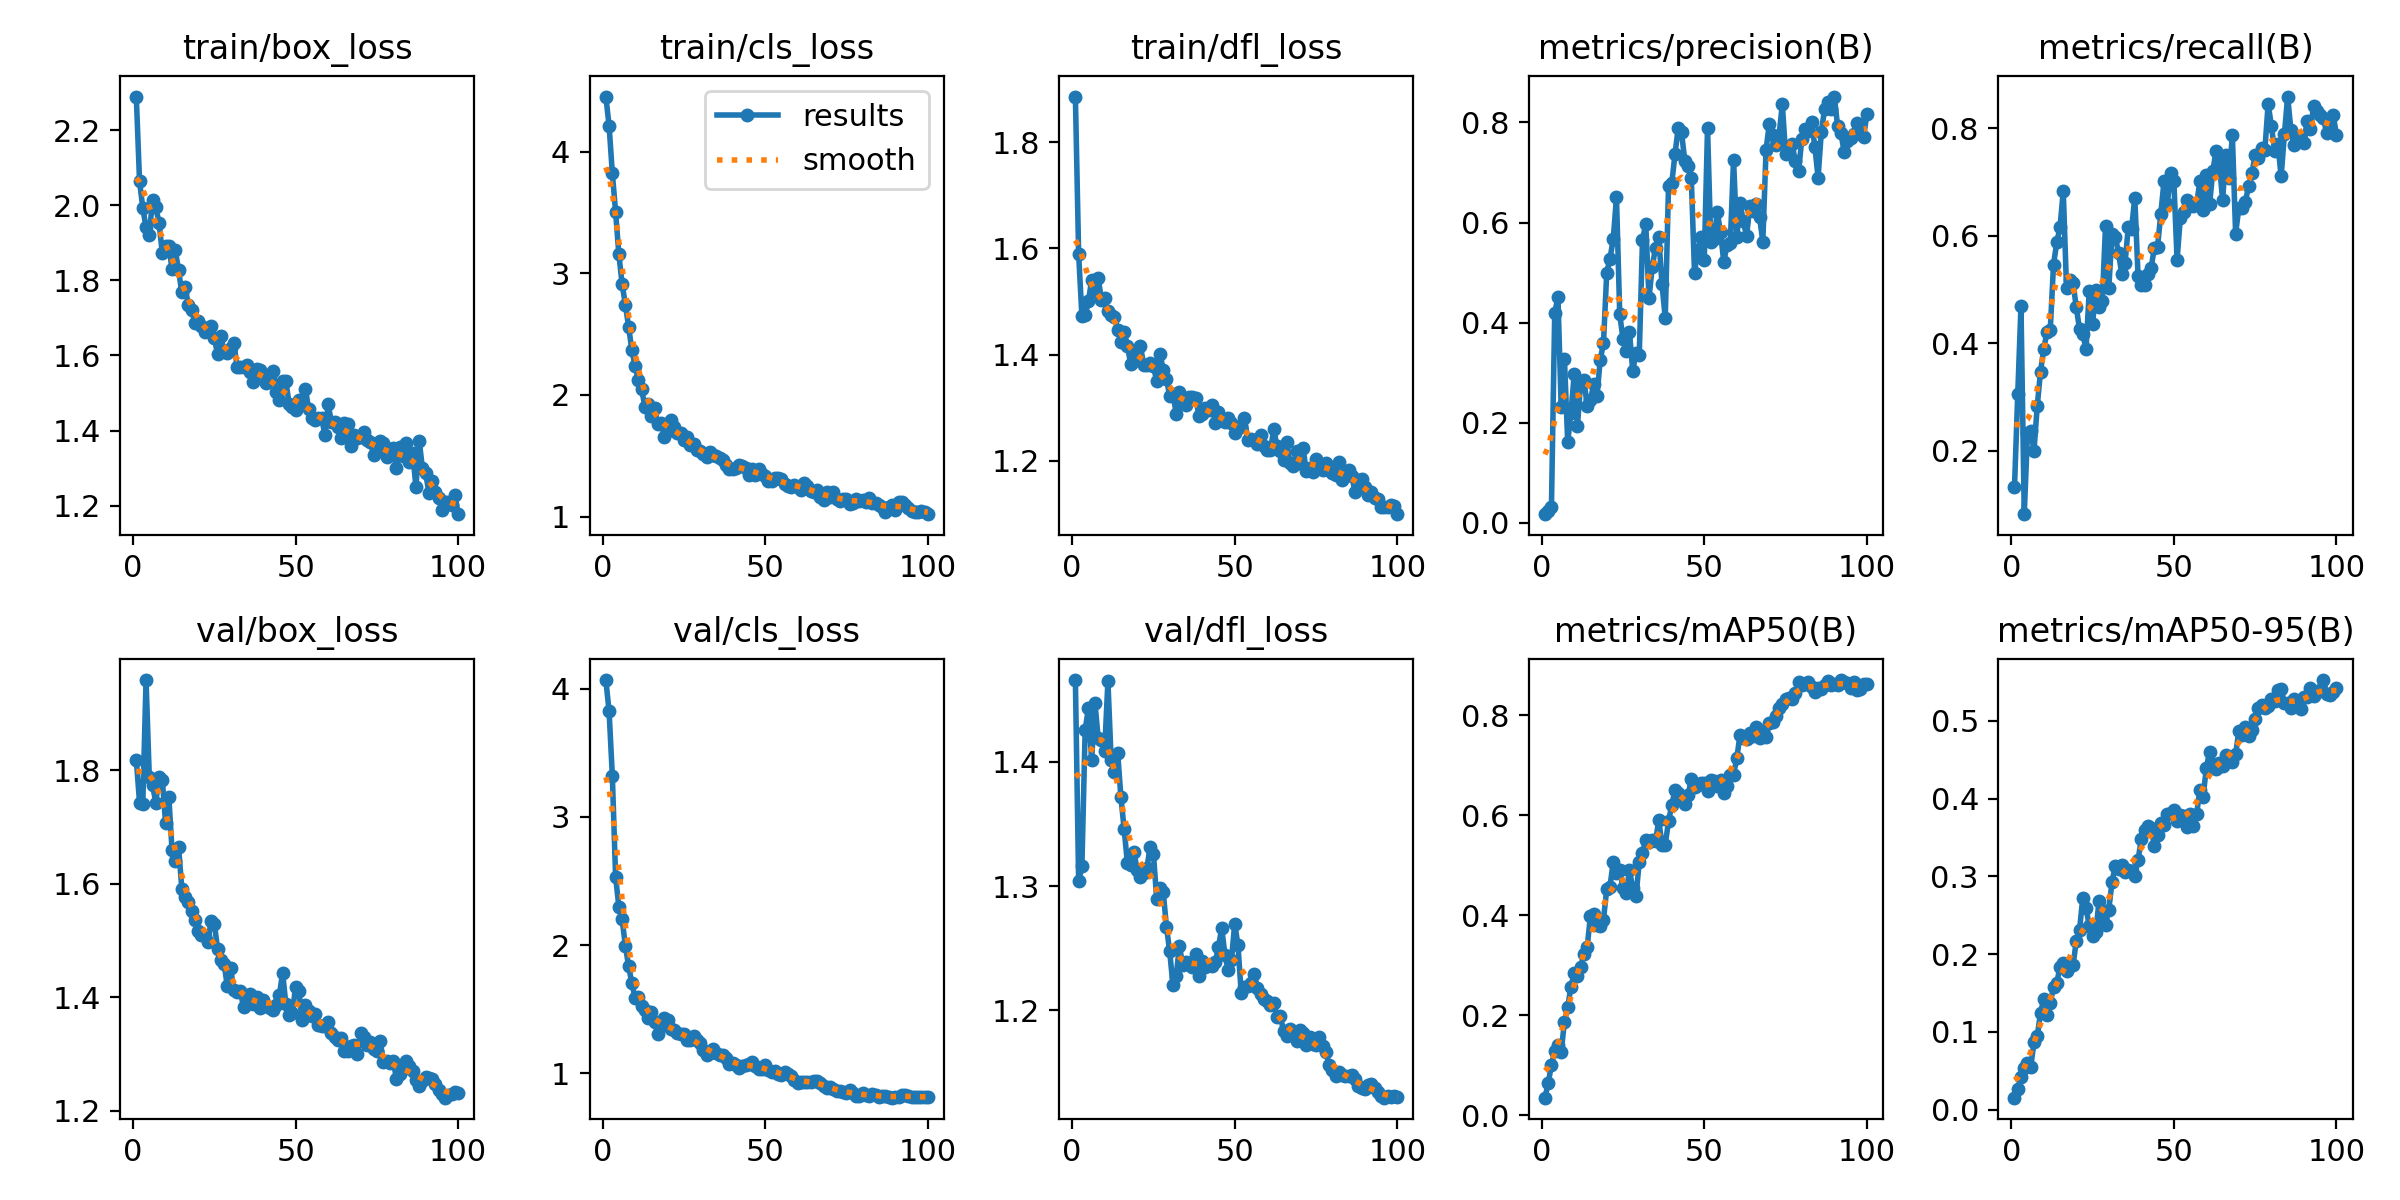

In [4]:
RUNS_BASE_DIR = Path(OUTPUT_DIR) / 'training_results'

results_plot = RUNS_BASE_DIR/'results.png'

if results_plot.exists():
    print("Found training curve plot:")
    display(Image(filename=str(results_plot))) 
else:
    print("'results.png' not found. Check if training ran successfully.")

### Save Model Export

In [5]:
# Export trained model weights for future notebooks
export_path = OUTPUT_DIR / "corn_yolo11n_baseline.pt"
model.save(export_path)
print(f"Model saved to: {export_path}")

Model saved to: runs/corn_baseline_yolov11n/corn_yolo11n_baseline.pt


### Report

In [6]:
map50_95 = metrics.box.map  
map50 = metrics.box.map50  
precision = metrics.box.mp.mean() if metrics.box.mp.size > 0 else 0  # Mean Precision
recall = metrics.box.mr.mean() if metrics.box.mr.size > 0 else 0    # Mean Recall

df_general = pd.DataFrame({
    'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)'],
    'Value': [map50, map50_95, precision, recall]
})

df_general.set_index('Metric', inplace=True)

print("--- Overall Metrics ---")
display(df_general)

--- Overall Metrics ---


,Value
Metric,
mAP@0.5,0.778685
mAP@0.5:0.95,0.452457
Precision (P),0.710939
Recall (R),0.730551


In [7]:

ap50_arr = metrics.box.ap50.flatten()
ap_arr = metrics.box.ap.flatten()
class_names_list = metrics.names
nc = len(class_names_list)
nc_evaluated = len(ap50_arr) 

data_list = []
for i in range(nc_evaluated): 
    data_list.append({
        'Class': class_names_list[i], 
        'mAP@0.5': ap50_arr[i],
        'mAP@0.5:0.95': ap_arr[i]
    })

df_class_wise = pd.DataFrame(data_list)

df_class_wise = df_class_wise[
    (df_class_wise['mAP@0.5'] > 0) | (df_class_wise['mAP@0.5:0.95'] > 0)
]
df_class_wise.set_index('Class', inplace=True)

print("\n--- Class-Wise Details ---")
display(df_class_wise)


--- Class-Wise Details ---


,mAP@0.5,mAP@0.5:0.95
Class,,
Blackbean,0.965649,0.625644
Canola,0.761840,0.402127
Corn,0.821923,0.404239
Field Pea,0.765179,0.500572
Flax,0.636786,0.319585
Horseweed,0.720733,0.462574
